# Cohort Retention Analysis with BART

In this notebook we study an alternative approach for the cohort analysis problem presented in [A Simple Cohort Retention Analysis in PyMC](https://juanitorduz.github.io/retention/). Instead of using a linear model to estimate the retention rate, we use a Bayesian Additive Regression Tree (BART) model(see [`pymc-bart`](https://www.pymc.io/projects/bart/en/latest/)). The BART model is a flexible non-parametric model that can be used to model complex relationships between the response and the predictors.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import pymc.sampling_jax
import pytensor.tensor as pt
import seaborn as sns
from scipy.special import logit
from sklearn.preprocessing import LabelEncoder


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
seed: int = sum(map(ord, "retention"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
random_seed_int: int = rng.integers(low=0, high=100, size=1).item()

## Read Data

Here we simply read the data from the previous post.

In [3]:
data_df = pd.read_csv("../data/retention_data.csv", parse_dates=["cohort", "period"])

data_df.head()

cohort  n_users     period   age  cohort_age  retention_true_mu  \
0 2020-01-01      150 2020-01-01  1430           0          -1.807373   
1 2020-01-01      150 2020-02-01  1430          31          -1.474736   
2 2020-01-01      150 2020-03-01  1430          60          -2.281286   
3 2020-01-01      150 2020-04-01  1430          91          -3.206610   
4 2020-01-01      150 2020-05-01  1430         121          -3.112983   

   retention_true  n_active_users  retention  
0        0.140956             150   1.000000  
1        0.186224              25   0.166667  
2        0.092685              13   0.086667  
3        0.038918               6   0.040000  
4        0.042575               2   0.013333

We make a data train-test split.

In [4]:
period_train_test_split = "2022-11-01"

train_data_df = data_df.query("period <= @period_train_test_split")
test_data_df = data_df.query("period > @period_train_test_split")
test_data_df = test_data_df[
    test_data_df["cohort"].isin(train_data_df["cohort"].unique())
]

## EDA

For a detailed EDA of the data, please refer to the previous post. Here we simply display the most important plots. First, here is the retention matrix:

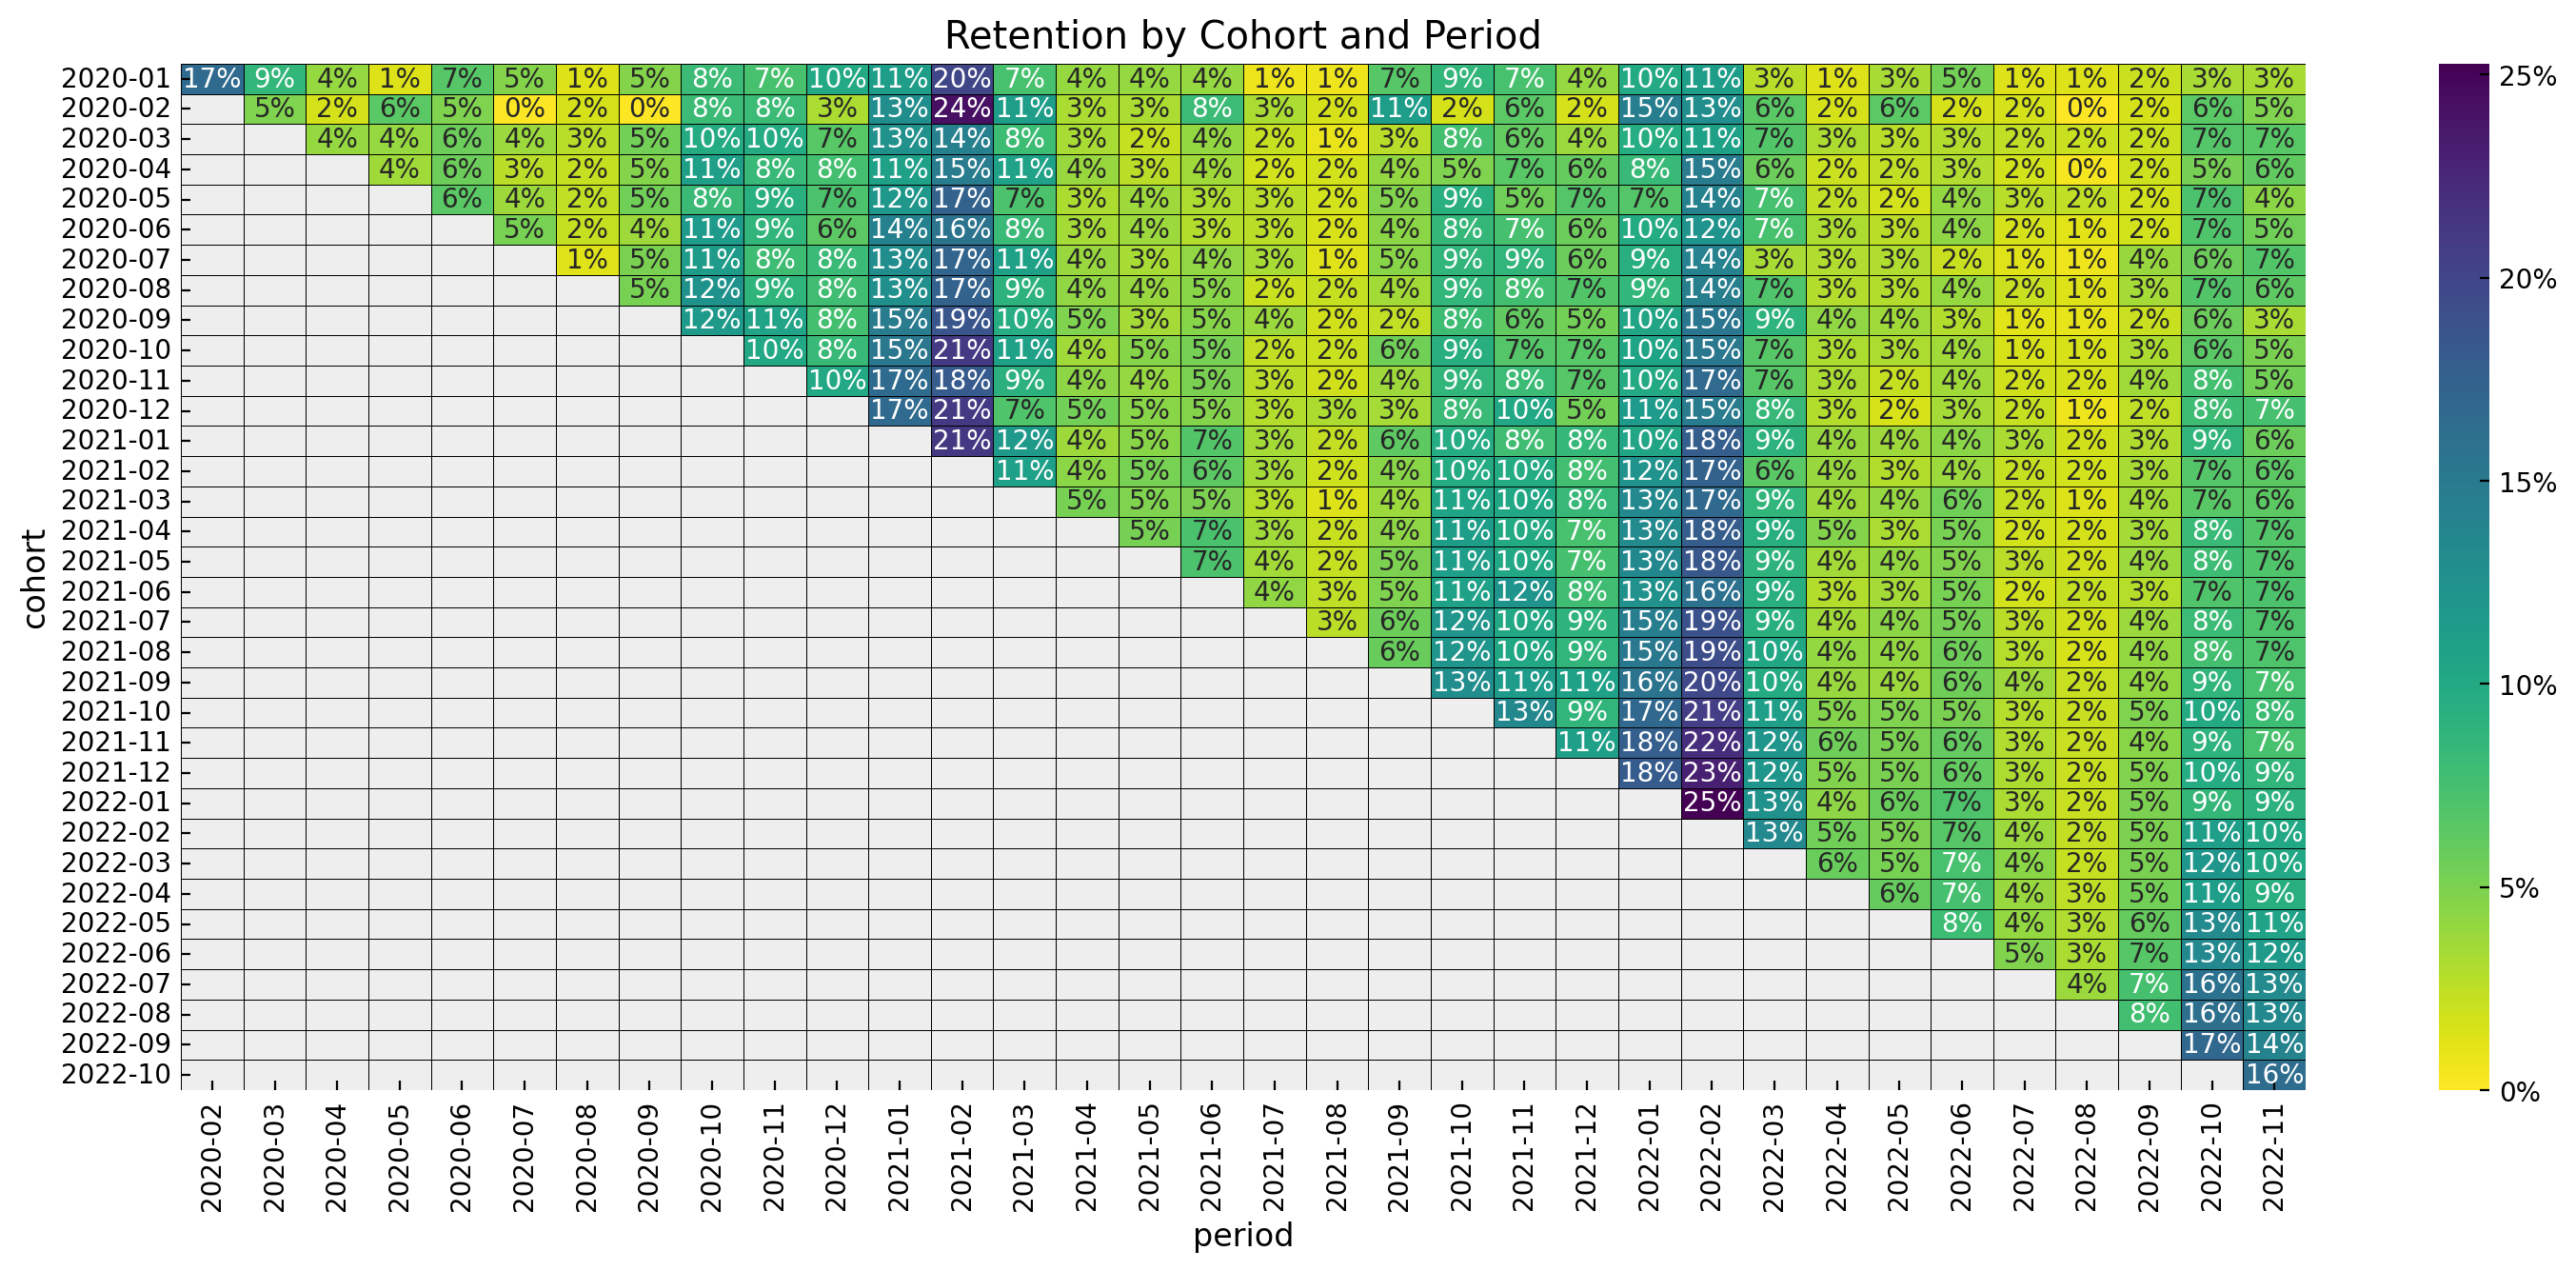

In [5]:
fig, ax = plt.subplots(figsize=(18, 7))

fmt = lambda y, _: f"{y :0.0%}"

(
    train_data_df.assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        period=lambda df: df["period"].dt.strftime("%Y-%m"),
    )
    .query("cohort_age != 0")
    .filter(["cohort", "period", "retention"])
    .pivot(index="cohort", columns="period", values="retention")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0%",
        cbar_kws={"format": mtick.FuncFormatter(fmt)},
        ax=ax,
    )
)

ax.set_title("Retention by Cohort and Period");

Next we plot the retention rate by cohort over time (period):

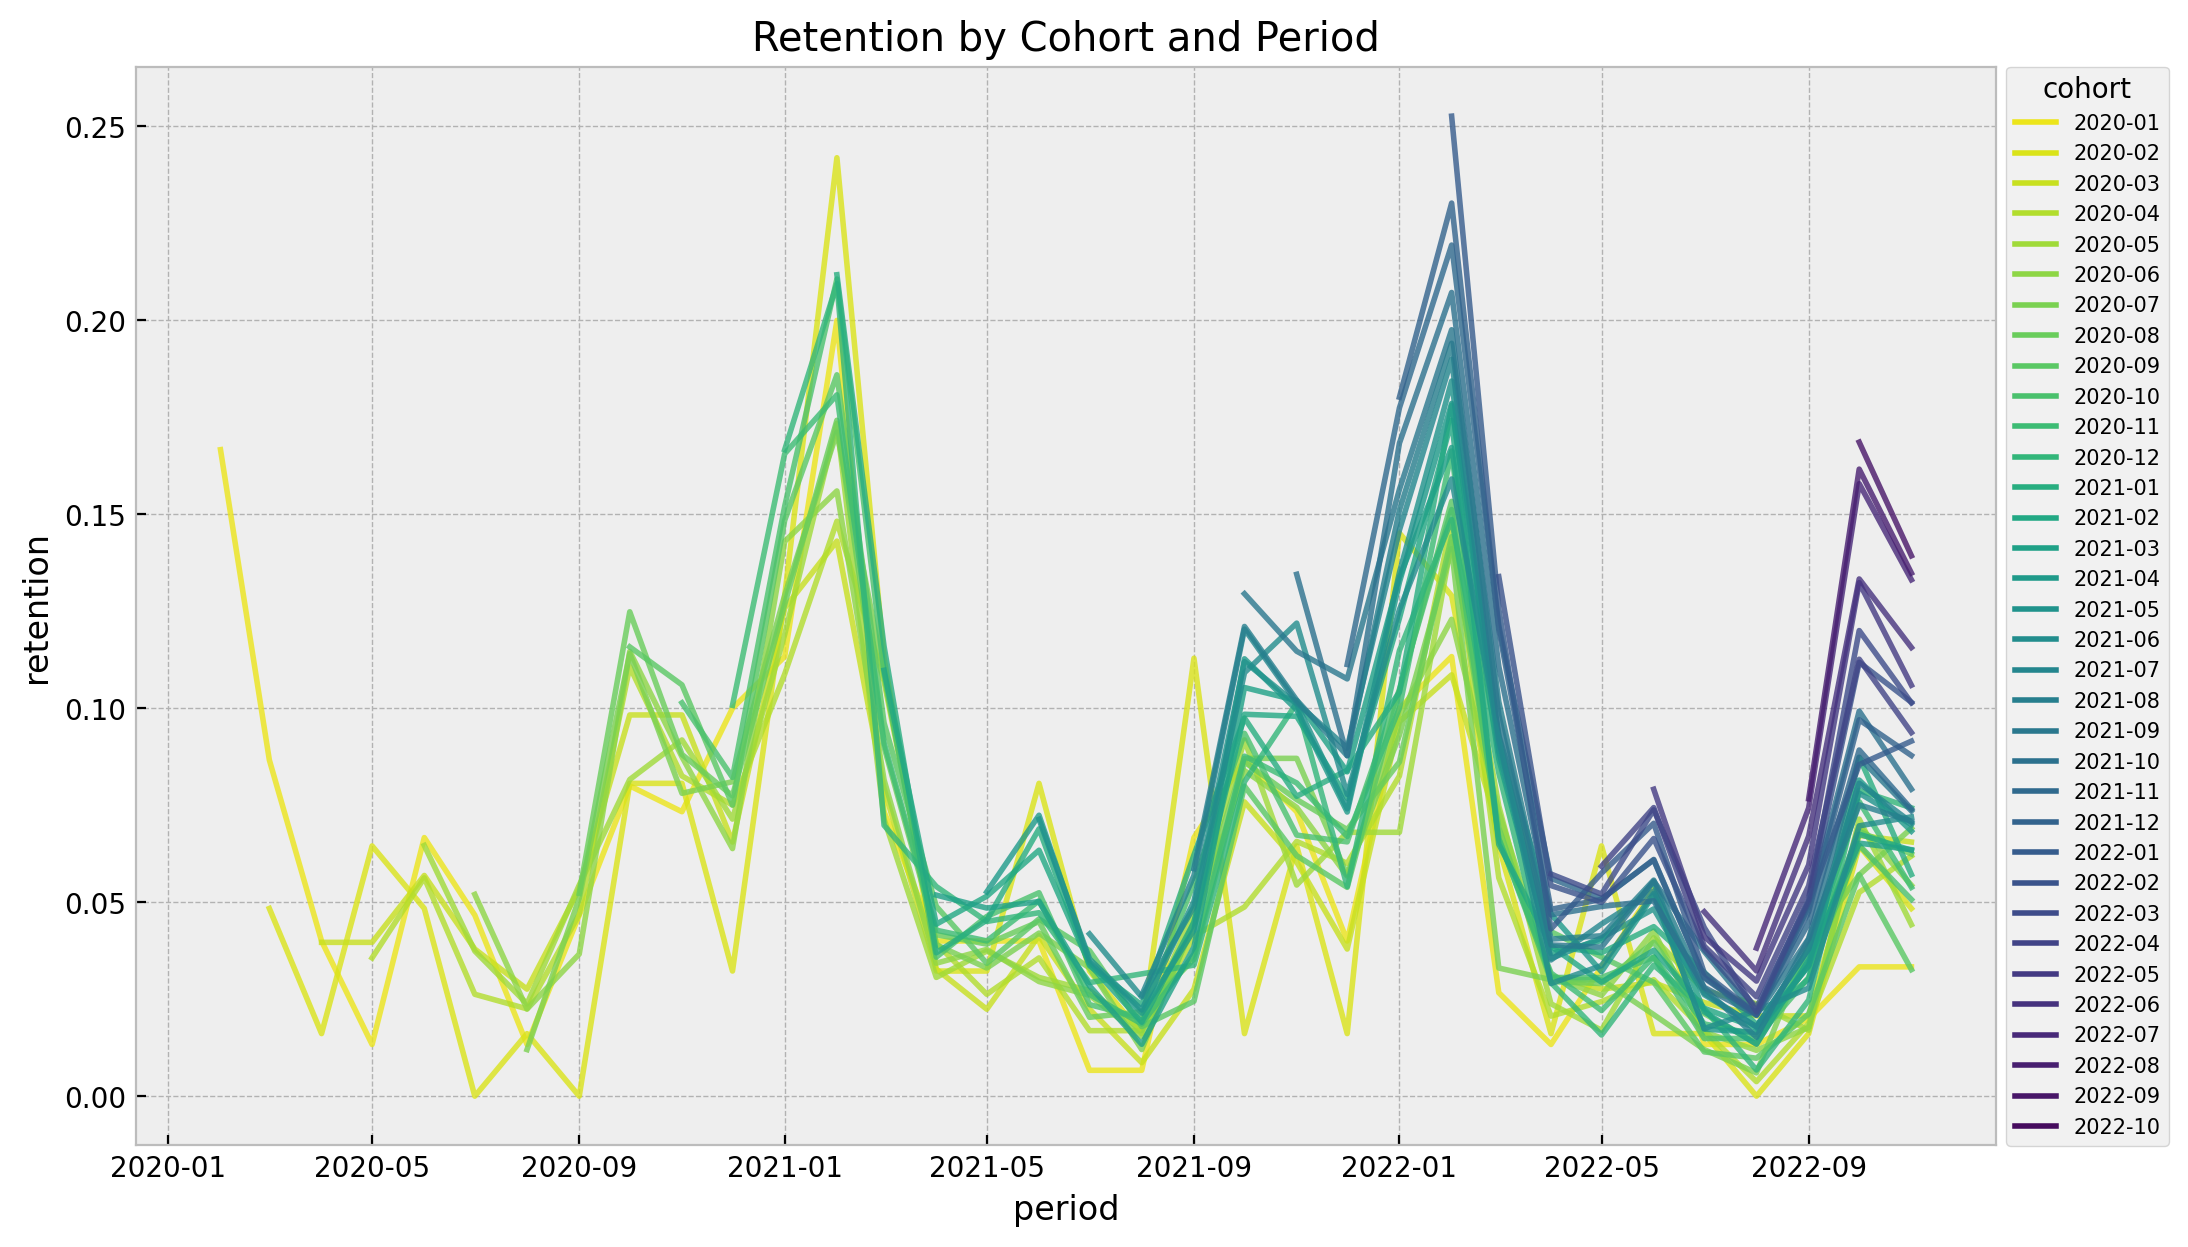

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(
    x="period",
    y="retention",
    hue="cohort",
    palette="viridis_r",
    alpha=0.8,
    data=train_data_df.query("cohort_age > 0").assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m")
    ),
    ax=ax,
)
ax.legend(title="cohort", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set(title="Retention by Cohort and Period");

As mentioned in the previous post, we see the following:

* It seems that for a given period, the retention rates of the new cohorts are higher than the retention rates of the older cohorts. This is a clear indication that the retention rate is a function of the absolute cohort age.
* We also see a clear seasonality component in the retention rates.
* For a given cohort, seasonality peaks are decreasing as a function of time (period).

## Model

The model we want to test is the following:

\begin{align*}
N_{\text{active}} & \sim \text{Binomial}(N_{\text{total}}, p) \\
\textrm{logit}(p) & = \text{BART}(\text{cohort age}, \text{age}, \text{month})
\end{align*}

That is, we want to use a BART model to estimate the retention rate as a function of the absolute cohort age, the cohort age and the month. Note that we do not need to specify the relation between variables, the BART model will learn it from the data.

### Data Transformations

We do similar transformations to the data as for the linear model.

In [7]:
eps = np.finfo(float).eps
train_data_red_df = train_data_df.query("cohort_age > 0").reset_index(drop=True)
train_obs_idx = train_data_red_df.index.to_numpy()
train_n_users = train_data_red_df["n_users"].to_numpy()
train_n_active_users = train_data_red_df["n_active_users"].to_numpy()
train_retention = train_data_red_df["retention"].to_numpy()
train_retention_logit = logit(train_retention + eps)
train_data_red_df["month"] = train_data_red_df["period"].dt.strftime("%m").astype(int)

train_cohort = train_data_red_df["cohort"].to_numpy()
train_cohort_encoder = LabelEncoder()
train_cohort_idx = train_cohort_encoder.fit_transform(train_cohort).flatten()
train_period = train_data_red_df["period"].to_numpy()
train_period_encoder = LabelEncoder()
train_period_idx = train_period_encoder.fit_transform(train_period).flatten()

features: list[str] = ["age", "cohort_age", "month"]
x_train = train_data_red_df[features]

### Model Specification

We strongly recommend to take a look into the [BART Overview](https://www.pymc.io/projects/bart/en/latest/examples/BART_introduction.html) section presented in the `pymc-bart` documentation. One thing to note is that in all examples presented, the BART model is used to model the expected value of the response variable. In our case, we have a Binomial likelihood, so we need to apply the logit link function to the BART component (Thank you [Osvaldo A Martin](https://github.com/aloctavodia) for the support and indication on some numerical tips and tricks!, see [this issue](https://github.com/pymc-devs/pymc-bart/issues/31)). Let's see how to do it:

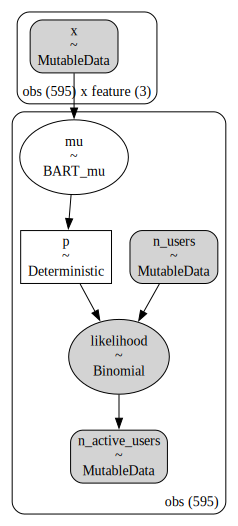

In [8]:
with pm.Model(coords={"feature": features}) as model:

    # --- Data ---
    model.add_coord(name="obs", values=train_obs_idx, mutable=True)
    x = pm.MutableData(name="x", value=x_train, dims=("obs", "feature"))
    n_users = pm.MutableData(name="n_users", value=train_n_users, dims="obs")
    n_active_users = pm.MutableData(
        name="n_active_users", value=train_n_active_users, dims="obs"
    )

    # --- Parametrization ---
    # The BART component models the image of the retention rate under the logit transform
    # so that the range is not constrained to [0, 1].
    mu = pmb.BART(name="mu", X=x, Y=train_retention_logit, m=30, dims="obs")
    # We use the inverse logit transform to get the retention rate back into [0, 1].
    p = pm.Deterministic(name="p", var=pm.math.invlogit(mu), dims="obs")
    # We add a small epsilon to avoid numerical issues.
    p = pt.switch(pt.eq(p, 0), eps, p)
    p = pt.switch(pt.eq(p, 1), 1 - eps, p)

    # --- Likelihood ---
    pm.Binomial(name="likelihood", n=n_users, p=p, observed=n_active_users, dims="obs")

pm.model_to_graphviz(model=model)

### Model Fitting

Now we are ready to fit the model.

In [9]:
with model:
    idata = pm.sample(draws=2_000, chains=4, random_seed=rng)
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)


Multiprocess sampling (4 chains in 4 jobs)
PGBART: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 145 seconds.
Sampling: [likelihood]


### Model Diagnostics

We look into the posterior predictive check:

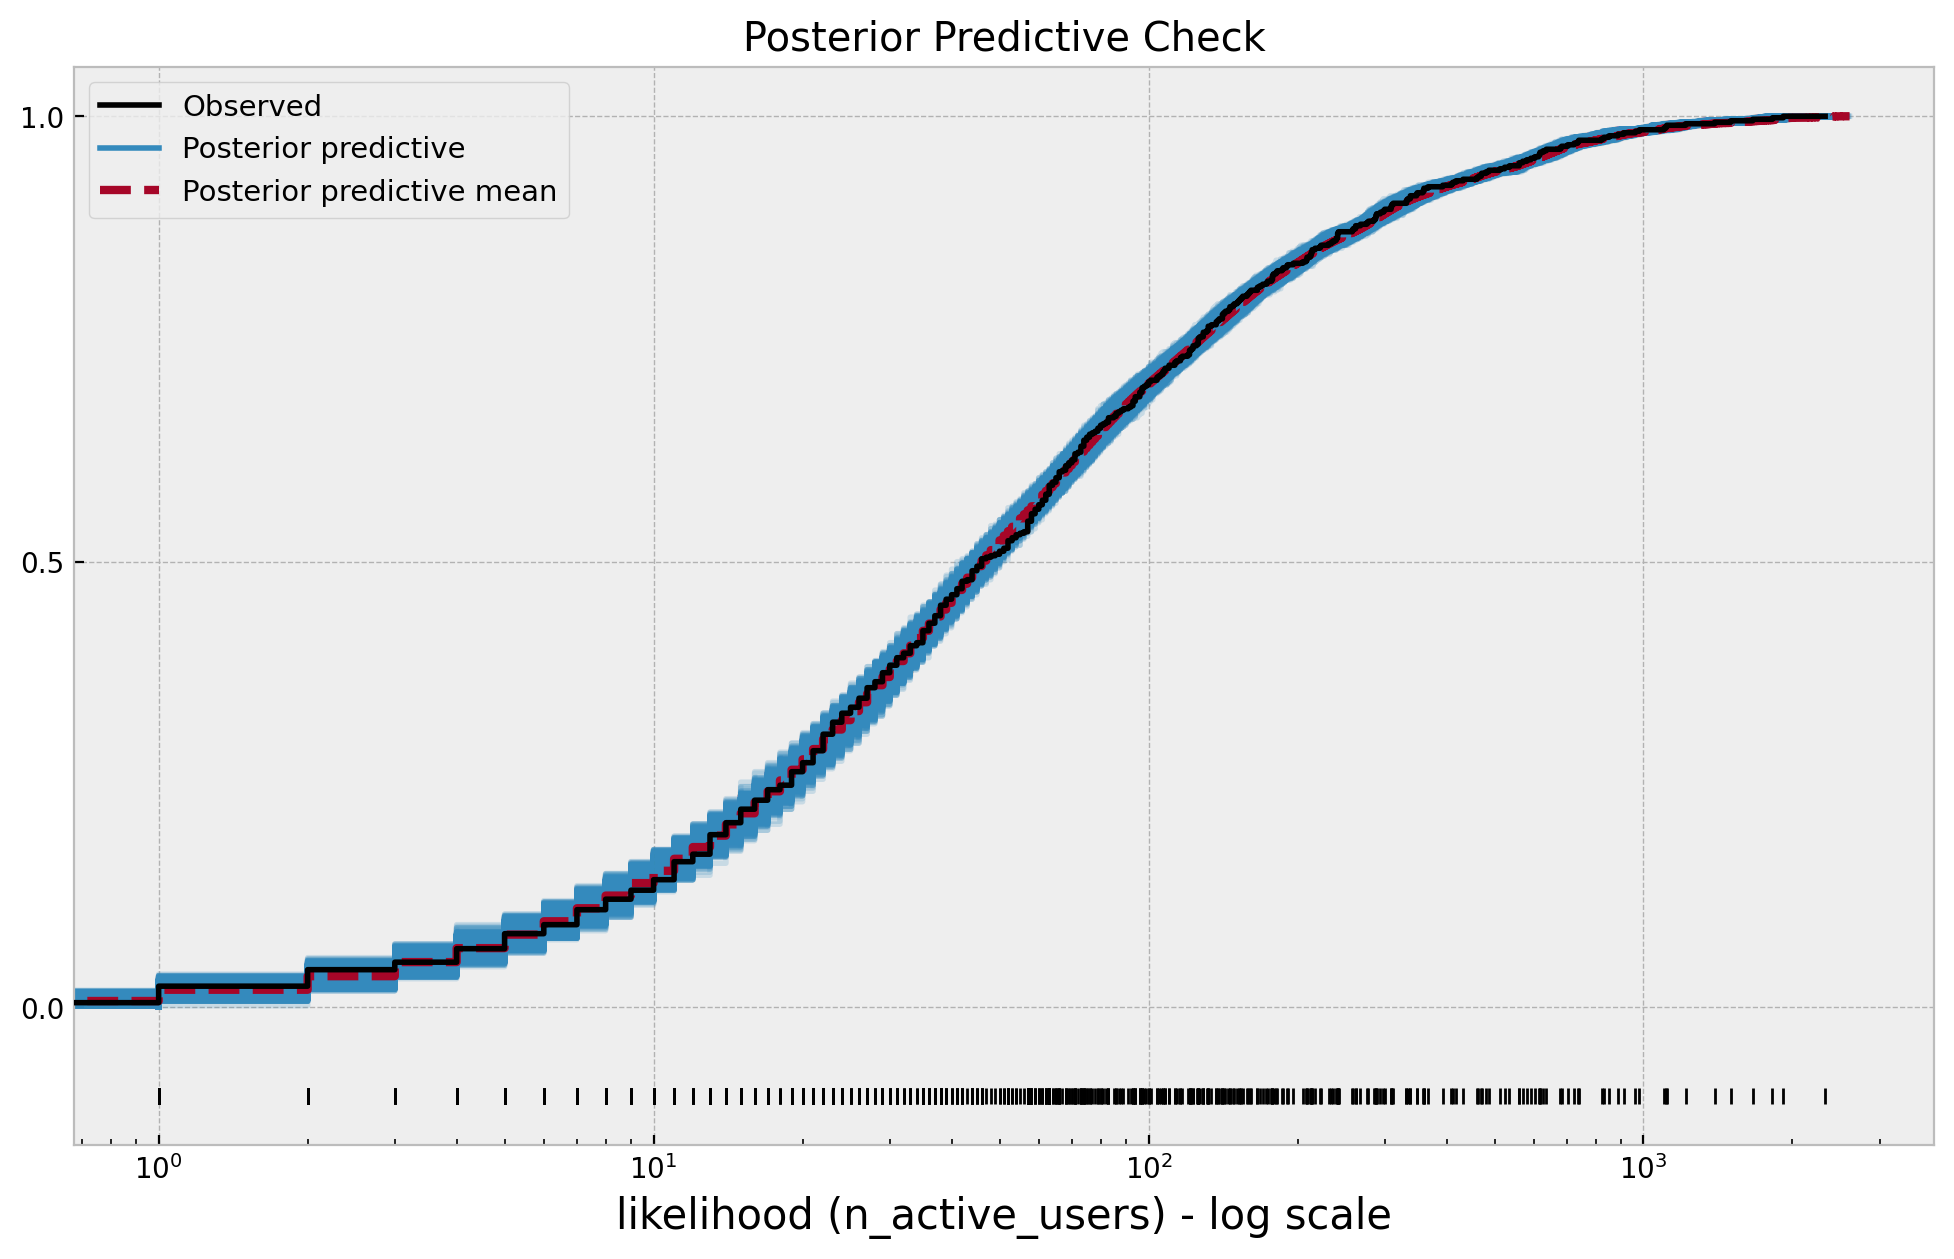

In [10]:
ax = az.plot_ppc(
    data=posterior_predictive,
    kind="cumulative",
    observed_rug=True,
    random_seed=random_seed_int,
)
ax.set(
    title="Posterior Predictive Check",
    xscale="log",
    xlabel="likelihood (n_active_users) - log scale",
);

The model seems to be doing a good job 🙂 ! 

### Retention Rate In-Sample Predictions

Let's see how the model performs in-sample. We plot the retention rate posterior mean predictions for the training data:

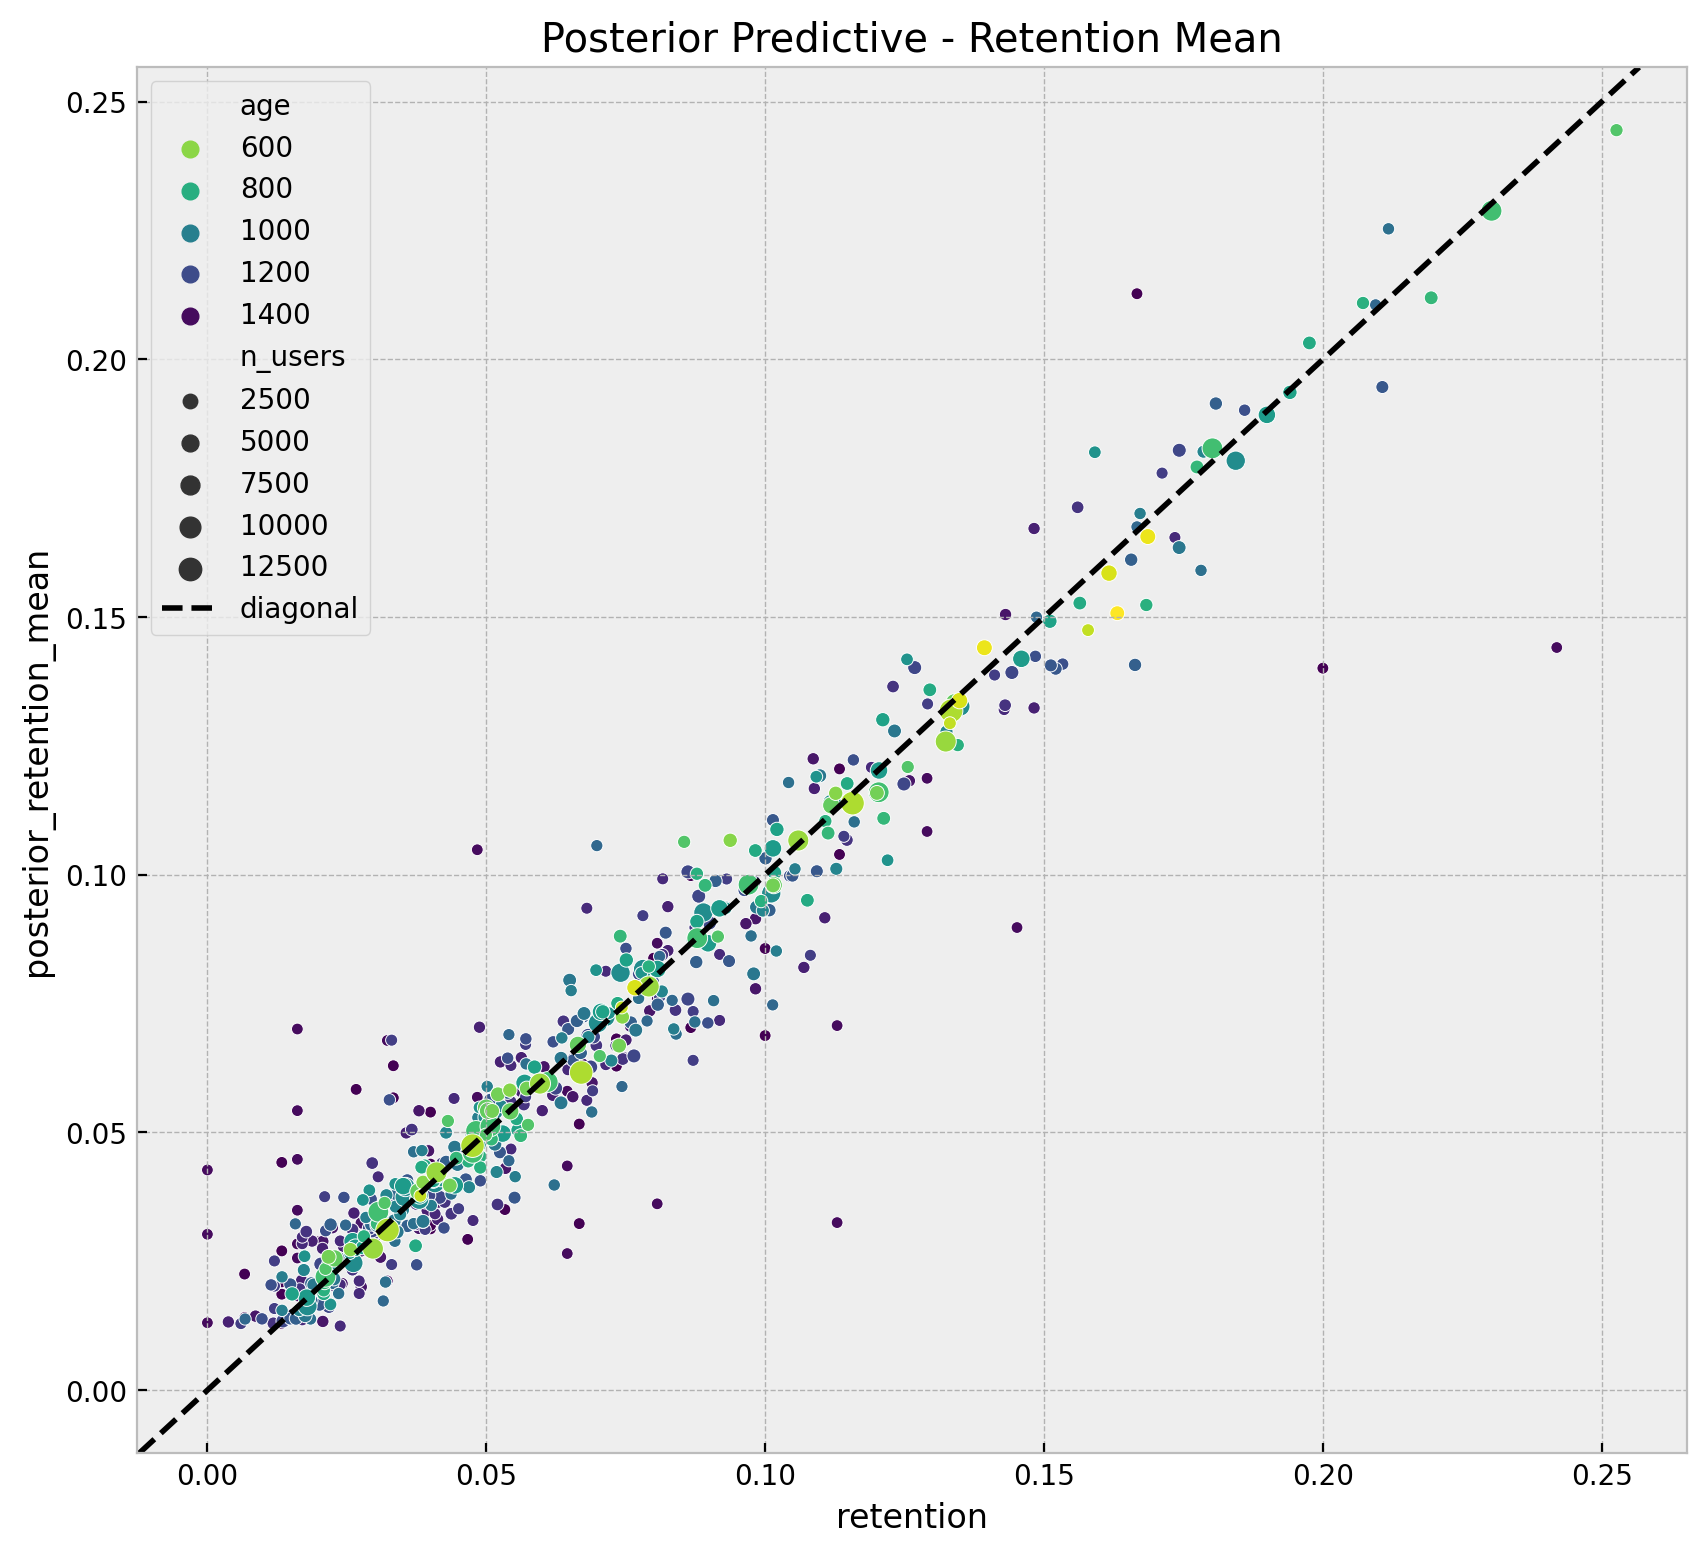

In [11]:
train_posterior_retention = (
    posterior_predictive.posterior_predictive / train_n_users[np.newaxis, None]
)
train_posterior_retention_mean = az.extract(
    data=train_posterior_retention, var_names=["likelihood"]
).mean("sample")

fig, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(
    x="retention",
    y="posterior_retention_mean",
    data=train_data_red_df.assign(
        posterior_retention_mean=train_posterior_retention_mean
    ),
    hue="age",
    palette="viridis_r",
    size="n_users",
    ax=ax,
)
ax.axline(xy1=(0, 0), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(title="Posterior Predictive - Retention Mean");

The results look quite good and similar to the linear model!

Next, we look into the uncertainty estimates for a subset of individual cohorts:

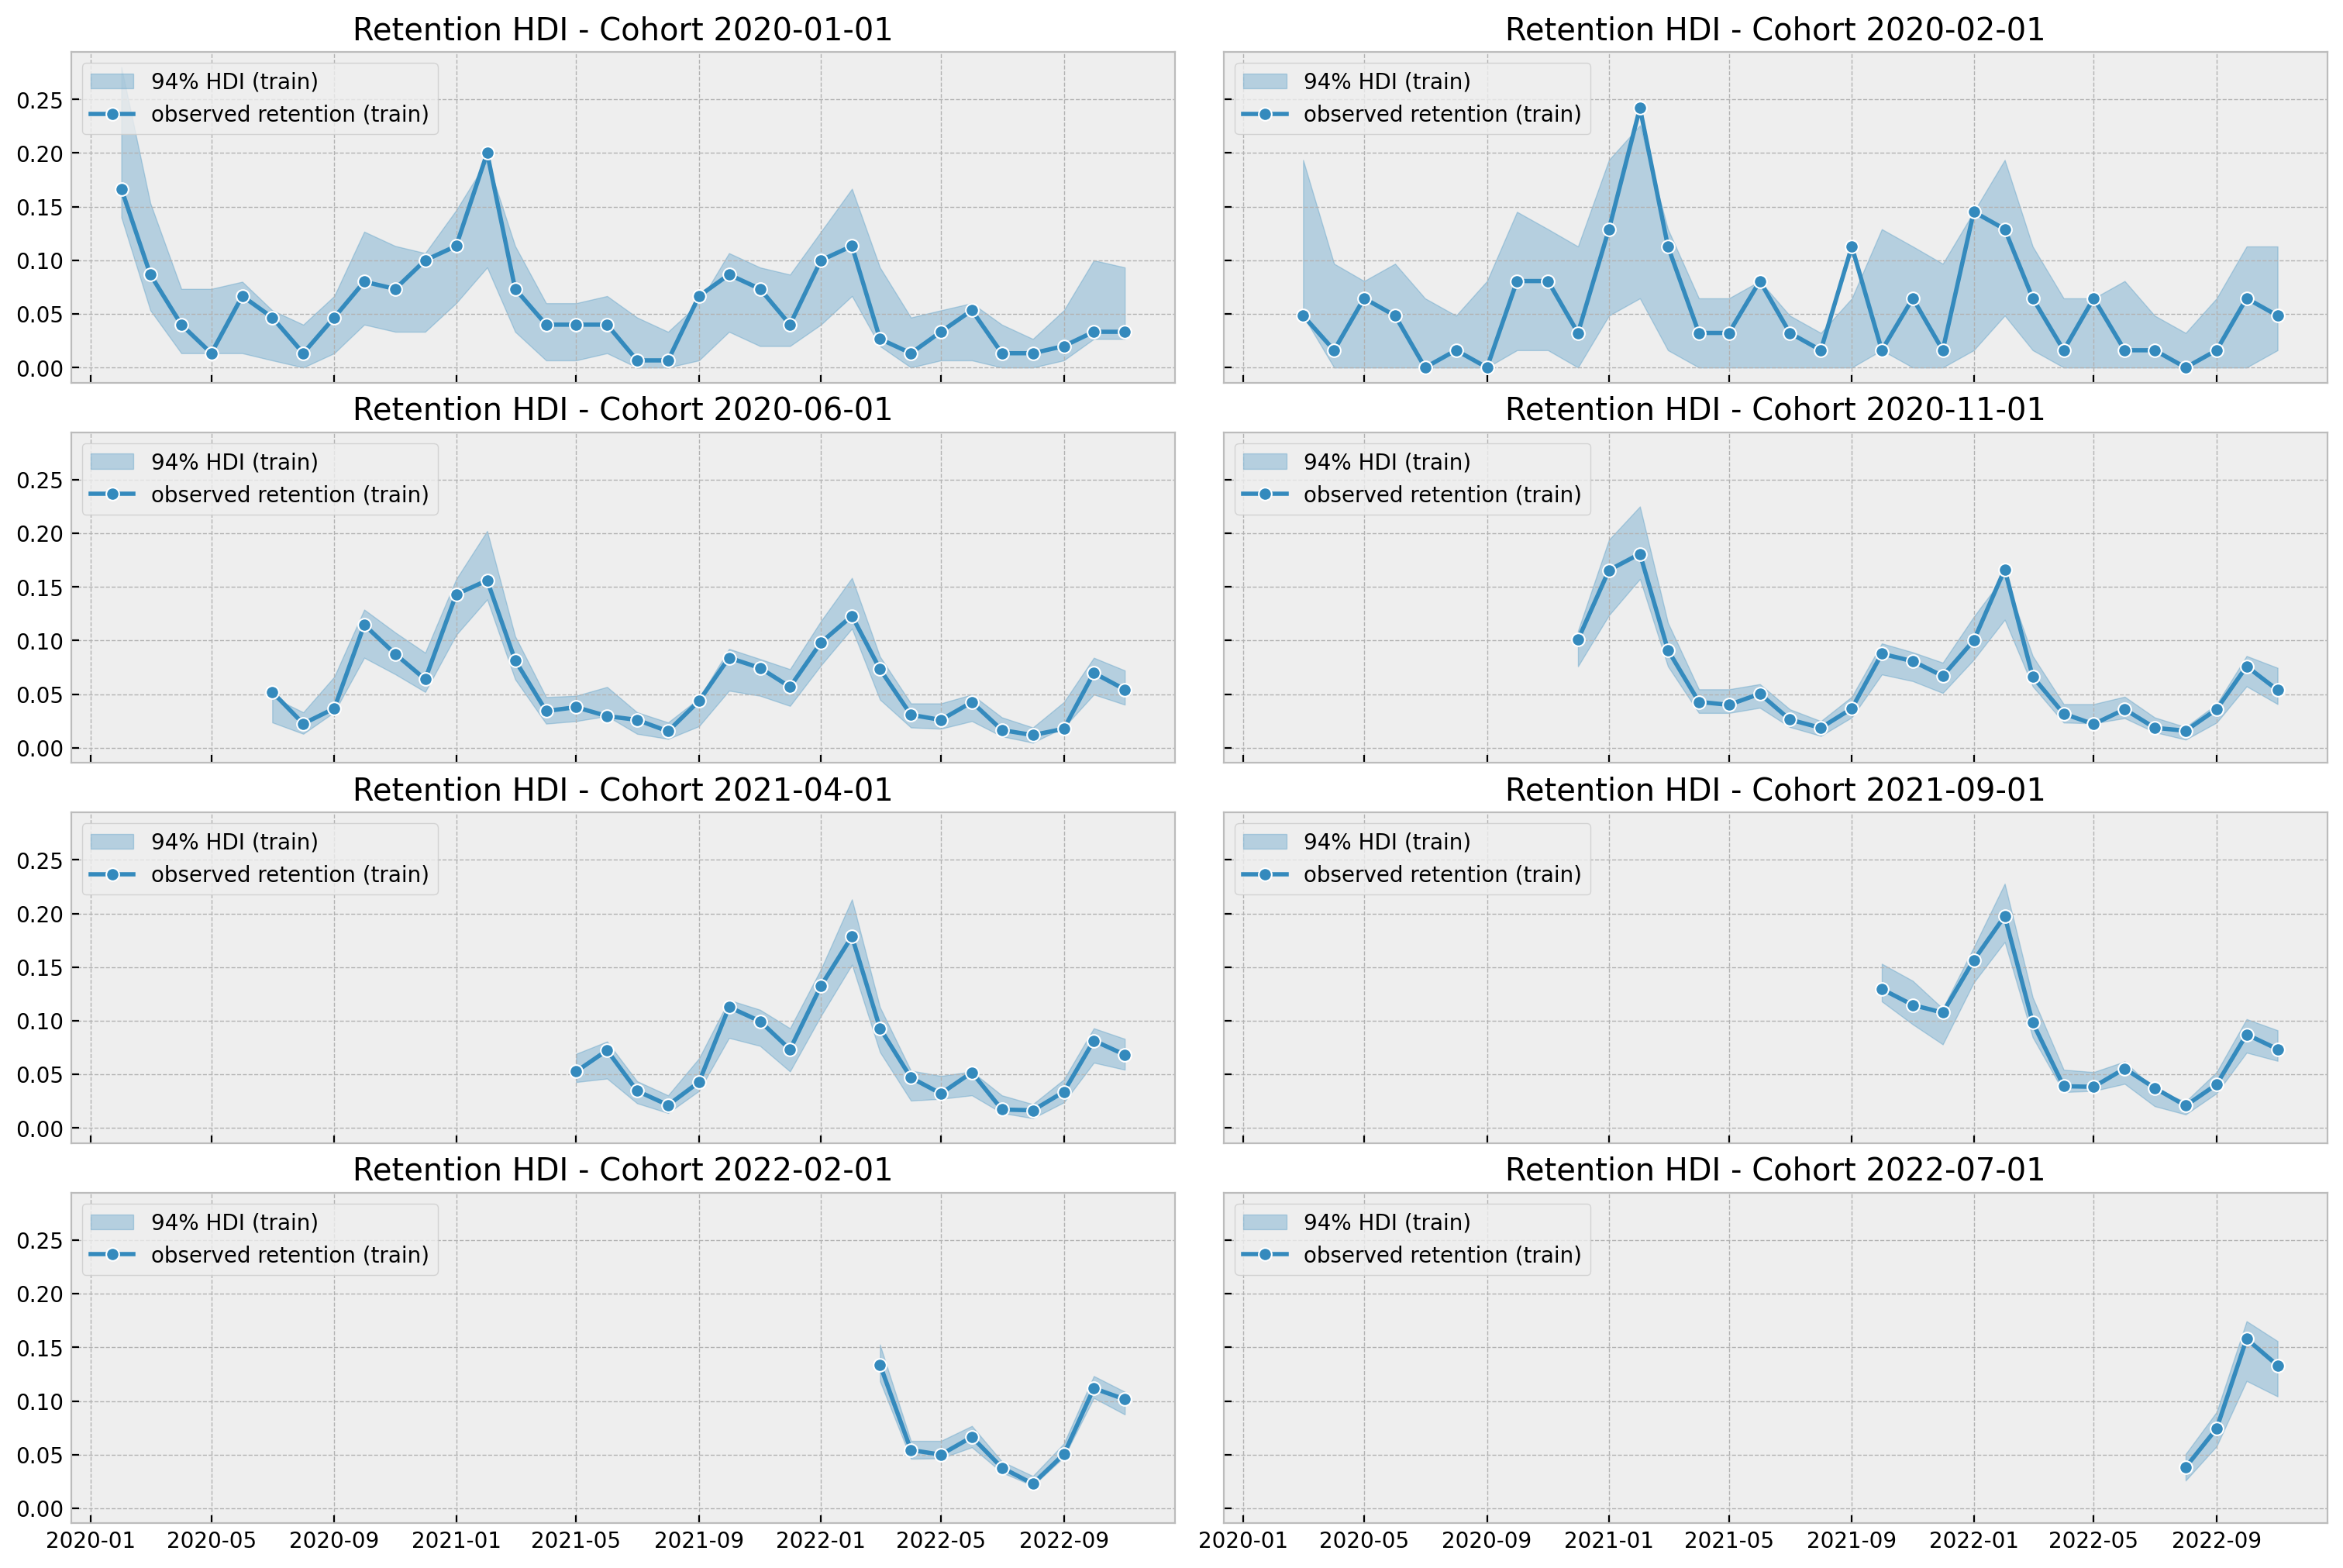

In [12]:
train_retention_hdi = az.hdi(ary=train_posterior_retention)["likelihood"]


def plot_train_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:

    mask = train_cohort_idx == cohort_index

    ax.fill_between(
        x=train_period[train_period_idx[mask]],
        y1=train_retention_hdi[mask, :][:, 0],
        y2=train_retention_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C0",
        label="94% HDI (train)",
    )
    sns.lineplot(
        x=train_period[train_period_idx[mask]],
        y=train_retention[mask],
        color="C0",
        marker="o",
        label="observed retention (train)",
        ax=ax,
    )
    cohort_name = (
        pd.to_datetime(train_cohort_encoder.classes_[cohort_index]).date().isoformat()
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Retention HDI - Cohort {cohort_name}")
    return ax


cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

fig, axes = plt.subplots(
    nrows=np.ceil(len(cohort_index_to_plot) / 2).astype(int),
    ncols=2,
    figsize=(15, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten()):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)

As in the linear model case, we are capturing the retention rate development over time. The uncertainty estimates are also quite similar to the linear model.

### PDP / ICE Plots

One of the nice features of the `pymc-bart` implementation is that it allows to compute partial dependence plots (PDP) and individual conditional expectation (ICE) plots. These plots help to understand relationships between the response and the predictors. For more details, please refer to the great book   [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/pdp.html) by Christoph Molnar. For a specific example in python with `scikit-learn`, please refer to the blog post [Exploring Tools for Interpretable Machine Learning](https://juanitorduz.github.io/interpretable_ml/).

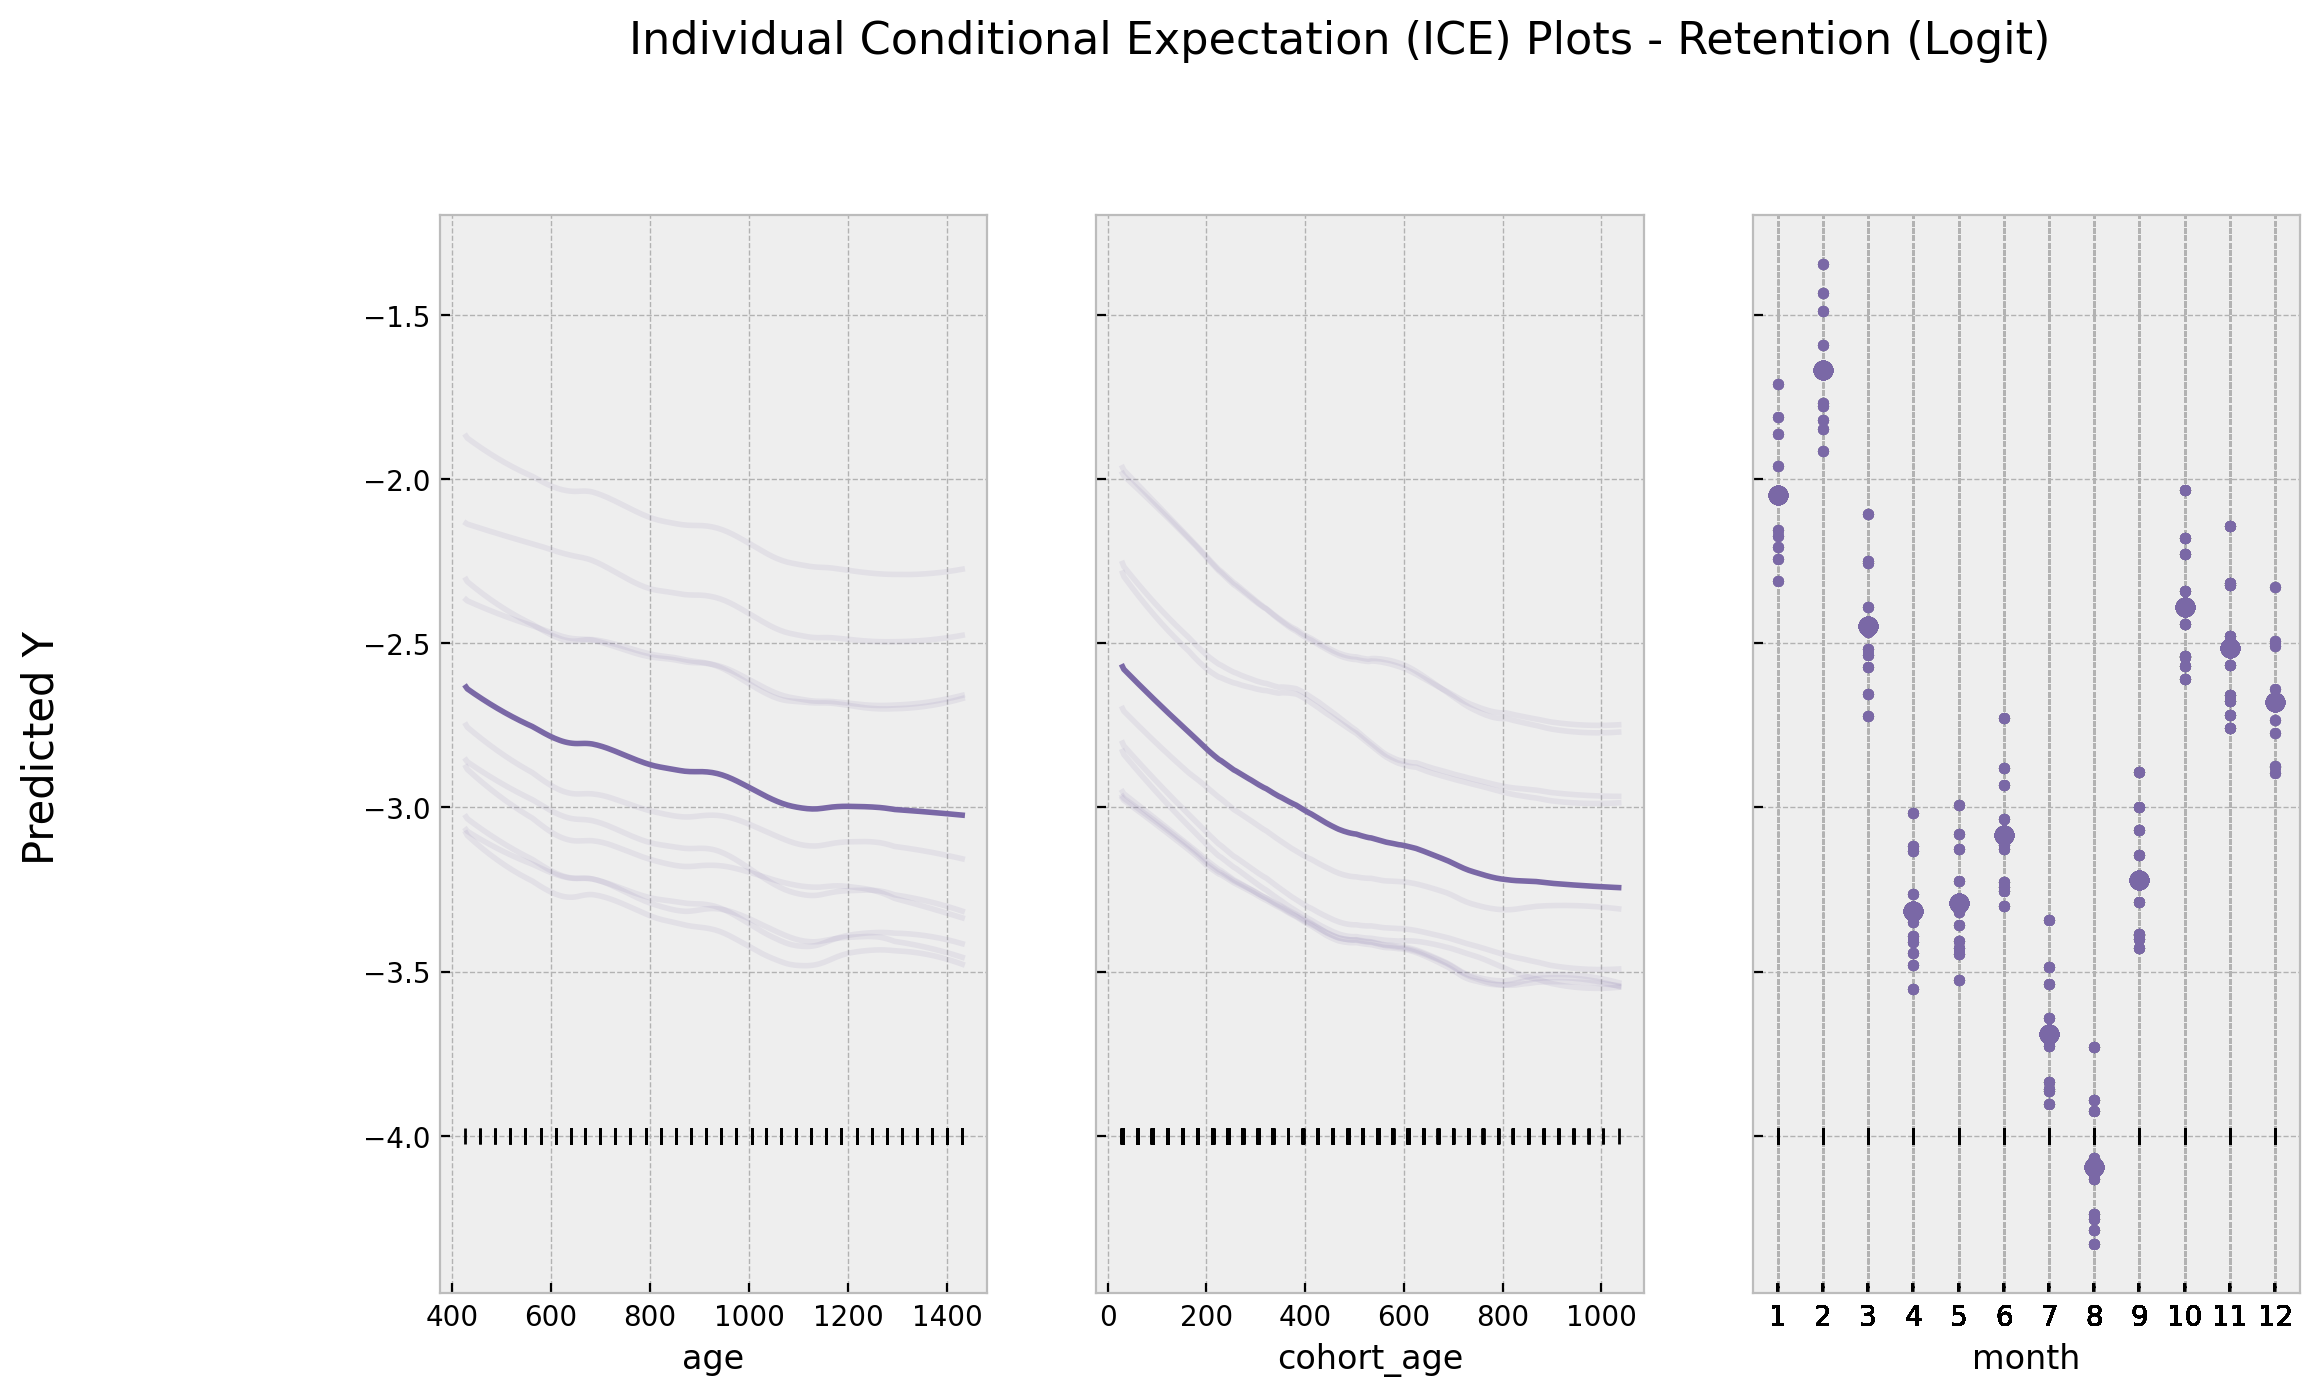

In [13]:
axes = pmb.plot_dependence(
    bartrv=mu,
    X=x_train,
    Y=train_retention_logit,
    xs_interval="quantiles",
    kind="ice",
    grid="wide",
    color="C2",
    color_mean="C2",
    var_discrete=[2],
    figsize=(12, 7),
    random_seed=random_seed_int,
)
plt.gcf().suptitle(
    "Individual Conditional Expectation (ICE) Plots - Retention (Logit)",
    fontsize=16,
    y=1.02,
);

- The PDP / ICE plots how the retention rate (logit) decreases with both `cohort_age` and `age`. This is not surprising as we saw in the EDA.
- We see that the ICE plots have a similar trend to the PDP plots. This hints that the interaction effects are not so important in this case (this is also something wee see in the linear model where the interaction coefficient was relatively small).
- We clearly see the seasonality component of the PDP / ICE plots resemble the regression coefficients in the linear model. This iis simply representing the strong seasonal component of the data.

### Variable Importance

BART models `pymc` implementation also provide a measure of variable importance. According to the documentation:

> *BART itself leads to a simple heuristic to estimate variable importance. That is simple count how many times a variable is included in all the regression trees. The intuition is that if a variable is important they it should appears more often in the fitted trees that less important variables. While this heuristic seems to provide reasonable results in practice, there is not too much theory justifying this procedure, at least not yet.*

In addition, this BART implementation also provides a measure of variable importance based the contribution to the  $R^2$. For more details, please refer to the [documentation](https://www.pymc.io/projects/bart/en/latest/examples/BART_introduction.html#Variable-importance) regarding variable importance.

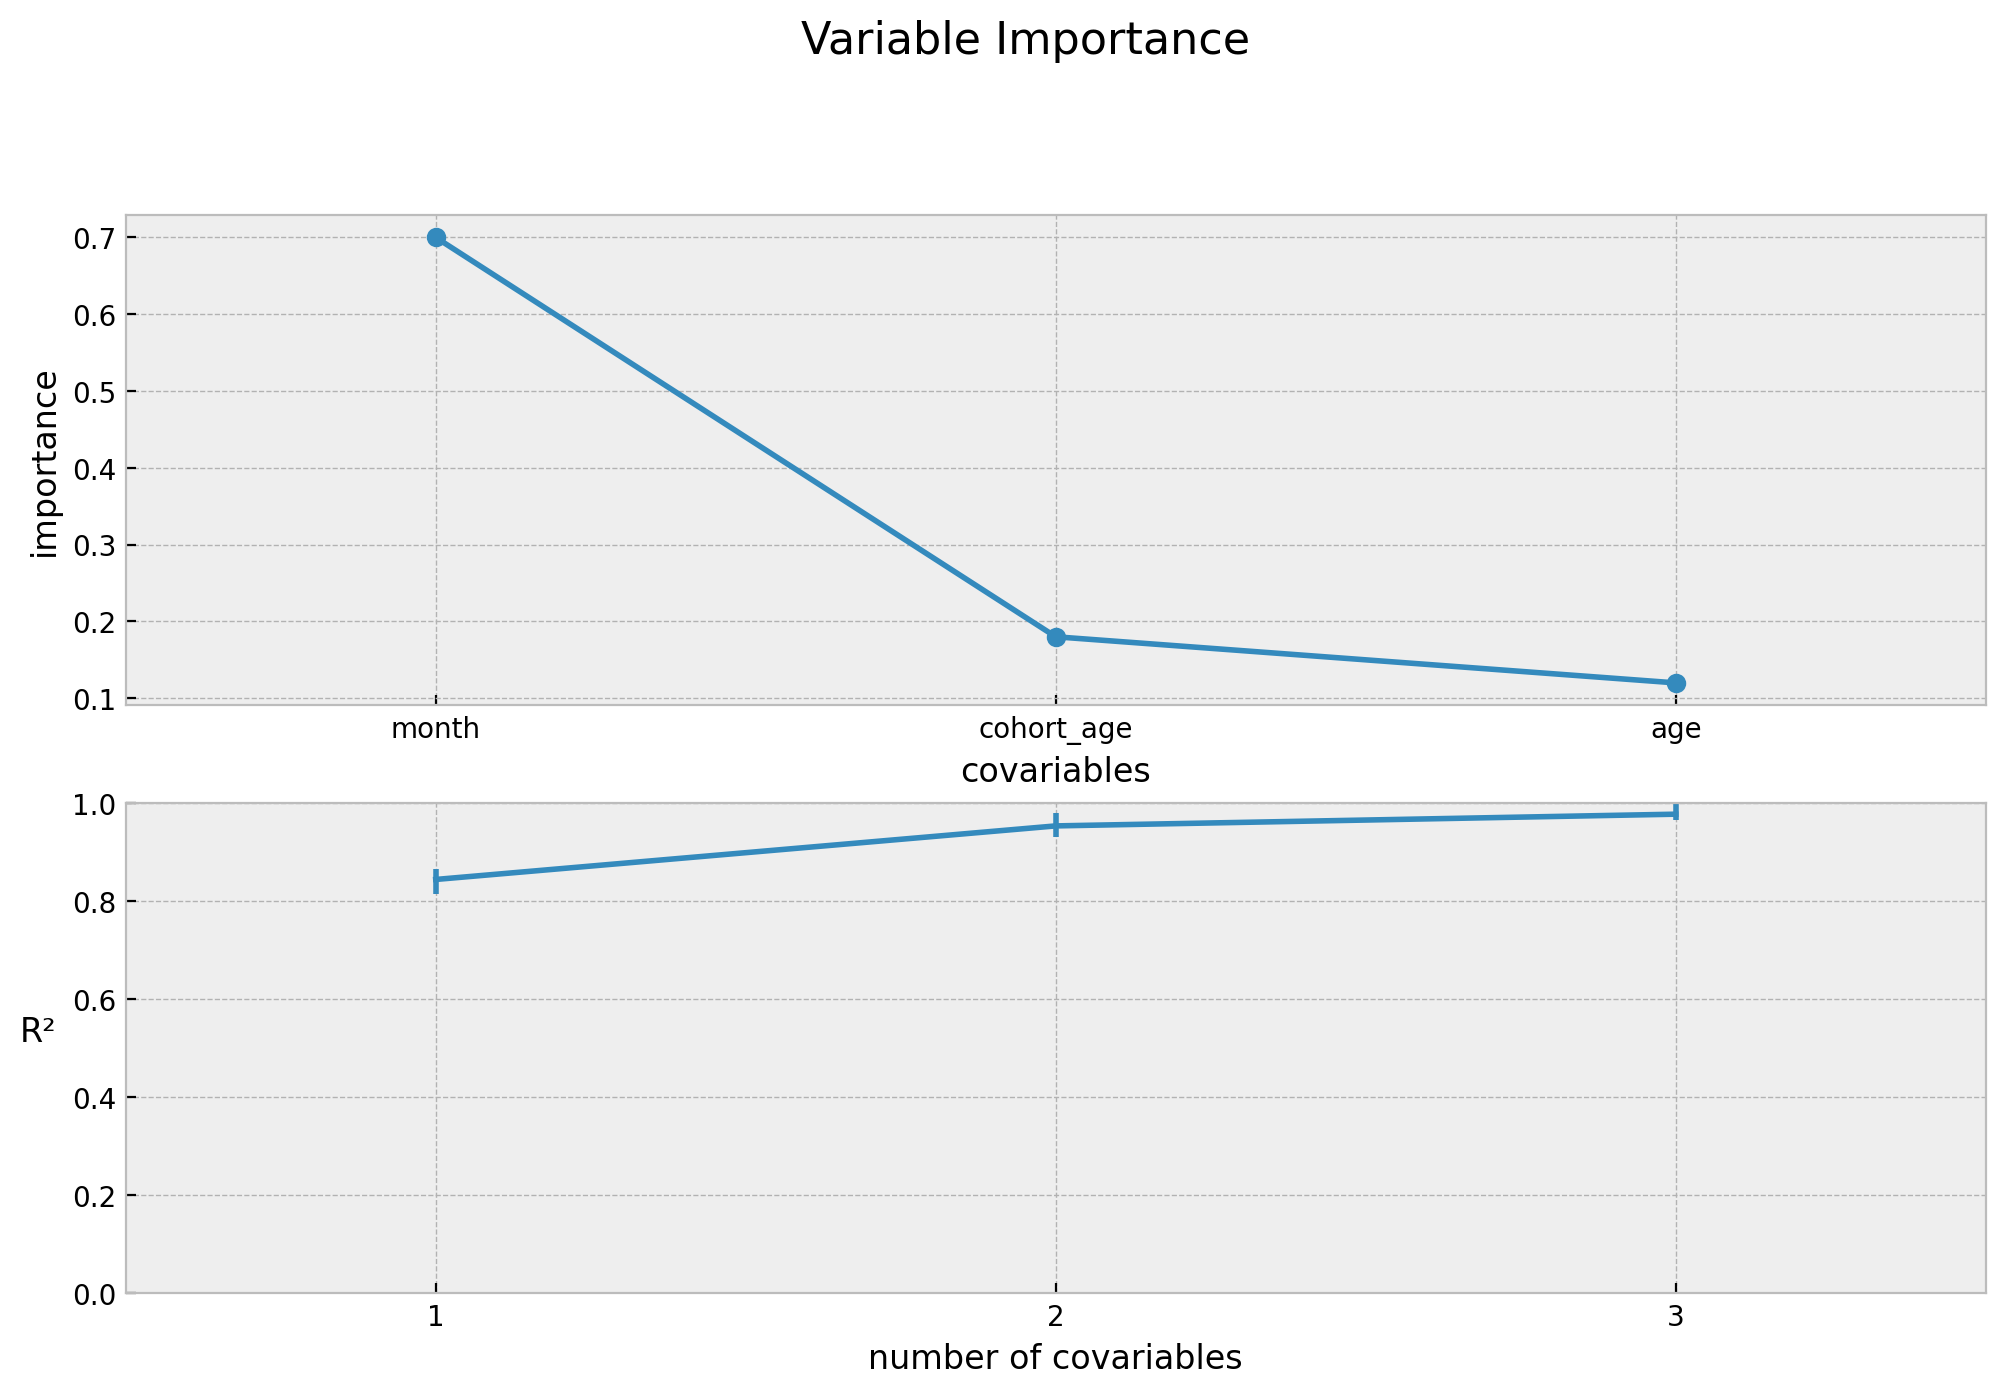

In [14]:
indices, axes = pmb.plot_variable_importance(
    idata=idata, bartrv=mu, X=x_train, random_seed=random_seed_int
)
plt.gcf().suptitle("Variable Importance", fontsize=16, y=1.02);

These plots suggest that the once we know the seasonal component and the `cohort_age`, the `age` variable is not so important.

## Predictions

Now we transform the test data to the same format as the training data and use the model to predict the retention rates. Note that we are using the scalers and encoders from the training data.

### Data Transformations

In [15]:
test_data_red_df = test_data_df.query("cohort_age > 0")
test_data_red_df = test_data_red_df[
    test_data_red_df["cohort"].isin(train_data_red_df["cohort"].unique())
].reset_index(drop=True)
test_obs_idx = test_data_red_df.index.to_numpy()
test_n_users = test_data_red_df["n_users"].to_numpy()
test_n_active_users = test_data_red_df["n_active_users"].to_numpy()
test_retention = test_data_red_df["retention"].to_numpy()

test_cohort = test_data_red_df["cohort"].to_numpy()
test_cohort_idx = train_cohort_encoder.transform(test_cohort).flatten()

test_data_red_df["month"] = test_data_red_df["period"].dt.strftime("%m").astype(int)
x_test = test_data_red_df[features]

### Out-of-Sample Posterior Predictions

Now we want to see out-of-sample predictions from this model. To begin, we need to compute the posterior predictive distribution for the test data.

In [16]:
with model:
    pm.set_data(
        new_data={
            "x": x_test,
            "n_users": test_n_users,
            "n_active_users": np.ones_like(
                test_n_active_users
            ),  # Dummy data to make coords work! We are not using this at prediction time!
        },
        coords={"obs": test_obs_idx},
    )
    idata.extend(
        pm.sample_posterior_predictive(
            trace=idata,
            var_names=["likelihood", "p", "mu"],
            idata_kwargs={"coords": {"obs": test_obs_idx}},
        )
    )

Sampling: [likelihood, mu]


### Retention Rate Out-of-Sample Predictions

Finally we compute the posterior retention rate distributions for the test data and visualize the results.

In [17]:
test_posterior_retention = (
    idata.posterior_predictive["likelihood"] / test_n_users[np.newaxis, None]
)

test_retention_hdi = az.hdi(ary=test_posterior_retention)["likelihood"]

In [18]:
def plot_test_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = test_cohort_idx == cohort_index

    test_period_range = test_data_red_df.query(
        f"cohort == '{train_cohort_encoder.classes_[cohort_index]}'"
    )["period"]

    ax.fill_between(
        x=test_period_range,
        y1=test_retention_hdi[mask, :][:, 0],
        y2=test_retention_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C1",
        label="94% HDI (test)",
    )
    sns.lineplot(
        x=test_period_range,
        y=test_retention[mask],
        color="C1",
        marker="o",
        label="observed retention (test)",
        ax=ax,
    )
    return ax

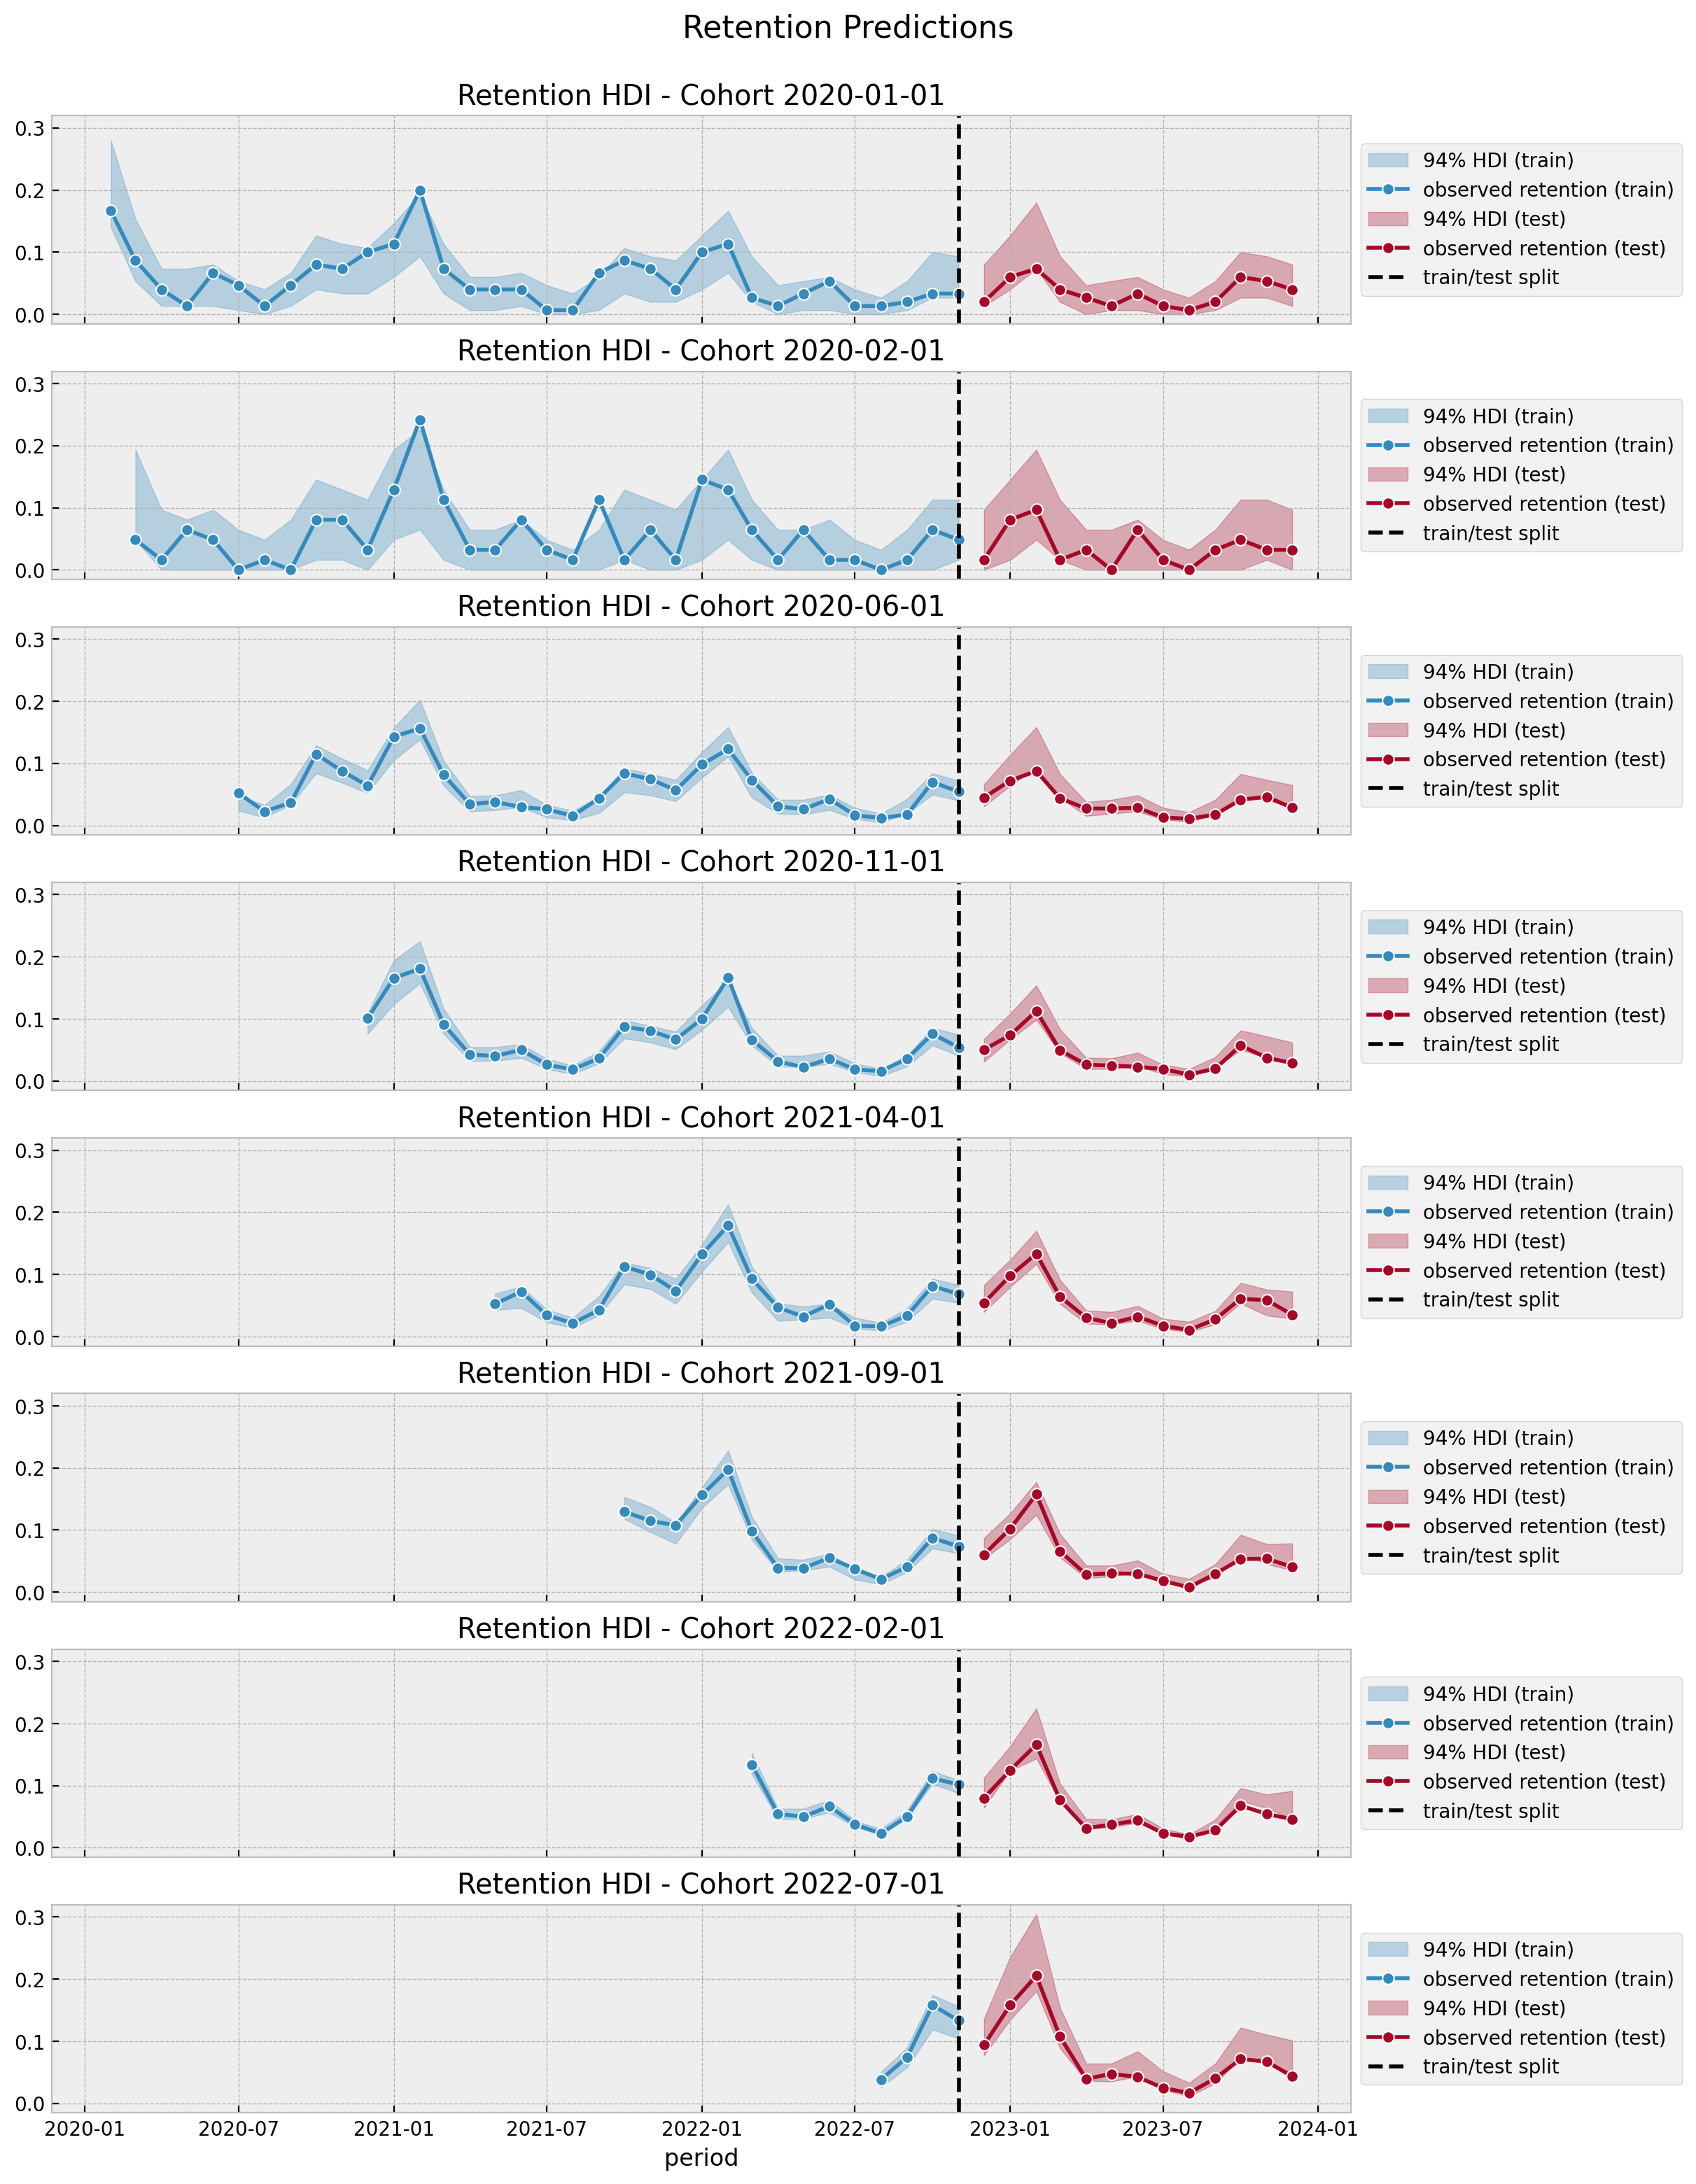

In [19]:
cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

fig, axes = plt.subplots(
    nrows=len(cohort_index_to_plot),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten()):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    plot_test_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    ax.axvline(
        x=pd.to_datetime(period_train_test_split),
        color="black",
        linestyle="--",
        label="train/test split",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.suptitle("Retention Predictions", y=1.03, fontsize=16);

These predictions look quite good as well! They actually do not differ much from linear model. The reason might be that the interaction effects do not seem strong (according to the PDP / ICE plots). That being said, the BART model is more flexible and can capture more complex relationships between the response and the predictors. This could be useful in real-world applications where the data and relationships are more complex.